### This notebook contans the entire optimization pipeline for the Northbound B20.

In [1]:
import location as lc
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
import dimod
import networkx as nx
import sys
import neal

In [2]:
stopsdf = pd.read_csv("../get_stops_data/b20-stops-data/b20-north-stops-final.csv")
stopsdf.head()

StopID                             Name       AtStreet BayNo       City  \
0   51202    WB HARRISON DR NS VICTORIA DR    VICTORIA DR     N  VANCOUVER   
1   51203  NB VICTORIA DR FS FRASERVIEW DR  FRASERVIEW DR     N  VANCOUVER   
2   51204       NB VICTORIA DR FS E 61 AVE       E 61 AVE     N  VANCOUVER   
3   51205  NB VICTORIA DR FS BRIGADOON AVE  BRIGADOON AVE     N  VANCOUVER   
4   51206      NB VICTORIA DR FS UPLAND DR      UPLAND DR     N  VANCOUVER   

         Lat        Long     OnStreet    Routes  WheelchairAccess   weights  
0  49.210673 -123.065781  HARRISON DR       020              True  0.233640  
1  49.212765 -123.065964  VICTORIA DR  020, N20              True  0.220238  
2  49.214832 -123.065913  VICTORIA DR  020, N20              True  0.253034  
3  49.216910 -123.065874  VICTORIA DR  020, N20              True  0.152653  
4  49.218398 -123.065832  VICTORIA DR  020, N20              True  0.162863

### Init bus stop objects from data frame
The bus stops must be in physical order.

In [3]:
stops = []

# iterate through each stop and init BusStop objects
j = 0

for stop in stopsdf.iloc:
    connectedness = len(stop['Routes'].split(','))
    bstop = lc.BusStop(stop['Lat'], stop['Long'], stop['StopID'],[], j, connectedness)
    bstop.weight = stop['weights']+1
    stops.append(bstop)
    j += 1


In [4]:
areadf = pd.read_csv("../stats-canada-data/DA.csv")
areadf.head()

DAuid  DApop_2016  DAtdwell_2016  DAurdwell_2016  DAarea  DAir_2016  \
0  59150307         632            273             254  0.2994          0   
1  59150308         501            223             203  0.1095          0   
2  59150309         745            299             269  0.1118          0   
3  59150310         536            310             283  0.1095          0   
4  59150311         532            199             181  0.0810          0   

       DArplamx      DArplamy    DArplat    DArplong  PRuid  CDcode  ADAcode  \
0  4.025164e+06  2.004585e+06  49.287698 -123.026031     59      15       59   
1  4.024986e+06  2.004256e+06  49.284329 -123.026065     59      15       59   
2  4.024664e+06  2.004196e+06  49.282483 -123.029585     59      15       59   
3  4.024866e+06  2.003949e+06  49.281378 -123.025534     59      15       59   
4  4.024531e+06  2.003835e+06  49.279058 -123.028871     59      15       59   

   DAcode  ERcode  CCScode  CSDcode  CMAuid  CTname  CTcode  
0     307      20       22       22     933   53.02    5286  
1     308      20       22       22     933   53.02    5286  
2     309      20       22       22     933   53.02    5286  
3     310      20       22       22     933   53.02    5286  
4     311      20       22       22     933   53.02    5286

In [5]:
areas = []

# iterate through each area and init Block objects
for area in areadf.iloc:
    area = lc.Block(area['DArplat'], area['DArplong'], area['DAuid'],int(area['DApop_2016']),int(area['DAurdwell_2016']), [])
    areas.append(area)

### For each stop we find neighboring areas within $x$ km

In [6]:
dist = 0.5
# find neighborhood for each stop
for stop in stops:
    stop.findNeighbors(areas, dist)

### Create a data frame for stops which contains StopID, Lat, Long and Connectedness

In [7]:
stopId = [stop.id for stop in stops]
lat = [stop.lat for stop in stops]
long = [stop.long for stop in stops]
conect = [stop.connectedness for stop in stops]
weights = [stop.weight for stop in stops]

d = {'stopId':stopId, 'lat':lat, 'long':long, 'connectedness':conect, 'weight':weights}
stopVizDf = pd.DataFrame(data=d)
stopVizDf.head()

stopId        lat        long  connectedness    weight
0   51202  49.210673 -123.065781              1  1.233640
1   51203  49.212765 -123.065964              2  1.220238
2   51204  49.214832 -123.065913              2  1.253034
3   51205  49.216910 -123.065874              2  1.152653
4   51206  49.218398 -123.065832              2  1.162863

### Create a data frame for all Areas which are in proximity to bus stops

In [8]:
route_areas_with_dups = []
# iterate though each stop and get areas,
# Since some stops share Areas this results in duplicates (it is supposed to be like that)
for stop in stops:
    route_areas_with_dups = route_areas_with_dups + stop.neighborhood

uniqueRouteAreas = set(route_areas_with_dups)

print('number of areas along the route:',len(uniqueRouteAreas))

areaId = [area.id for area in route_areas_with_dups]
lat = [area.lat for area in route_areas_with_dups]
long = [area.long for area in route_areas_with_dups]
popul = [area.pop for area in route_areas_with_dups]

d = {'areaId':areaId, 'lat':lat, 'long':long, 'pop':popul}
areaVizDf = pd.DataFrame(data=d)
areaVizDf.head()


number of areas along the route: 134


areaId        lat        long  pop
0  59151209.0  49.210165 -123.069500  667
1  59151211.0  49.213535 -123.062329  584
2  59151214.0  49.208190 -123.061474  628
3  59151215.0  49.207338 -123.063235  543
4  59153799.0  49.211912 -123.062435  285

### For each area we find neighboring bus stops.

In [9]:
def get_max_stops_per_area(uniqueRouteAreas, stops):
    """ return an area with most stops in its Nb and size of Nb """
    mostStopsPerArea = 0
    area_with_most_stops = 0
    
    for area in uniqueRouteAreas:
        area.findNeighbors(stops,dist)
        stopsPerArea = len(area.neighborhood)

        if stopsPerArea > mostStopsPerArea:
            mostStopsPerArea = stopsPerArea
            area_with_most_stops = area
    
    return area, mostStopsPerArea

area, mostStopsPerArea = get_max_stops_per_area(uniqueRouteAreas, stops)
print('most stops per area:', mostStopsPerArea, ', block with most stops:', area)

most stops per area: 6 , block with most stops: block id:59150422.0


### For each stop we find competitor bus stops

In [10]:
competDist = 0.3    # default 0.3
for stop in stops:
    stop.findCompetitors(stops, competDist)
    # set weight to 100 for start and end stops
    if stop.id == 51202 or stop.id == 61918:
        stop.weight = 100
    print(stop, ' competitors:', stop.competitors, 'weights:', stop.weight)

busStop id:51202  competitors: [busStop id:51203] weights: 100
busStop id:51203  competitors: [busStop id:51202, busStop id:51204] weights: 1.2202384064076128
busStop id:51204  competitors: [busStop id:51203, busStop id:51205] weights: 1.2530342550948976
busStop id:51205  competitors: [busStop id:51204, busStop id:51206] weights: 1.1526530178183299
busStop id:51206  competitors: [busStop id:51205, busStop id:51207] weights: 1.1628633261449508
busStop id:51207  competitors: [busStop id:51206] weights: 1.123083519543573
busStop id:51208  competitors: [busStop id:51209] weights: 1.1664143817390937
busStop id:51209  competitors: [busStop id:51208, busStop id:51210] weights: 1.4289154388383067
busStop id:51210  competitors: [busStop id:51209, busStop id:51211] weights: 1.3440163329919304
busStop id:51211  competitors: [busStop id:51210, busStop id:51212] weights: 1.2183655579422705
busStop id:51212  competitors: [busStop id:51211, busStop id:50652] weights: 1.34424451637845
busStop id:50652

### Star formulating objective function.  
#### QUBO as Taylor series  
Let $F_j$ be a competitor $r_1$-neighborhood and $A_j$ be a demand node $r_2$-neighborhood of a stop $j$ then
\begin{align*}
    f_j = \frac{W_{jj}X_j}{1+\sum_{i\in F_j}X_i}.
\end{align*}
where
\begin{align*}
    W_{jj} = w_j^{\alpha}\sum_{k \in A_j}a_k d_{jk}^{-\beta}.
\end{align*}
Put $x = \sum_{k\in F_j}X_k$.  
Taylor series with two term approx of $f_j$ at $c$ yields  
\begin{align*}
    f_j &\approx f(c_j) + f'(c_j)(x-c_j)\\
    &=\frac{1+2c_j}{(1+c_j)^2}W_{jj}X_j - \frac{W_{jj}X_jx}{(1+c_j)^2}.
\end{align*}
<br>
This implies the entries in the matrix $Q$ are
\begin{align*}
    Q_{jj} &= \frac{1+2c_j}{(1+c_j)^2}W_{jj}, \\
    Q_{ij} &= -\frac{W_{jj}}{(1+c_j)^2}.
\end{align*}
<br>
We can rewrite this as
\begin{align*}
    Q_{jj} &= \frac{1+2c_j}{(1+c_j)^2}W_{jj}, \\
    Q_{ij} &= -\frac{Q_{jj}}{1+2c_j}.
\end{align*}
<br>
For best approximation when $r = 300$m set $c_j = |F_j|$.  


In [11]:
# Define a distance function in meters
d = lambda X,Y: lc.kmDist(X,Y)*1000

def obj_func(X, uniqueRouteAreas, alpha, beta):
    """ Area oriented objective function """
    S = 0
    for area in uniqueRouteAreas:
        for stop in area.neighborhood:
            denom = 1
            # if a stop has stop competitors dive S_ij by denom
            if stop.competitors:
                for compet in stop.competitors:
#                     denom += X[compet.j]*d(area, compet)**(-beta)*compet.weight**alpha
                    denom += X[compet.j]

            S += area.pop*X[stop.j]*d(area,stop)**(-beta)*stop.weight**alpha/denom

    return S


def alt_obj_func(X, stops, alpha, beta):
    """ Stop oriented objective function. No p-constraint. """
    Z = 0
    # iterate though stops j
    for stop in stops:
        S_ij = stop.weight**alpha*X[stop.j]
        coef_j = 0
        denom = 1
        
        # compute coefficient for X_j
        for area in stop.neighborhood:
            coef_j += area.pop*d(area,stop)**(-beta)
        
        # compute denominator for X_j
        for compet in stop.competitors:
            denom += X[compet.j]
    
        S_ij *= coef_j/denom
        Z += S_ij
    return Z


def qubo_taylor_obj(stops, F, p,alpha, beta, p_constraint=True):
    """ Stop oriented QUBO objective function. Derived by applying Taylor approx
        to the modified SIC model. Full p-constraint gives very dense graph.
        Parameters:
            F - penalty scaler, set to zero to ignore the constraint sum(X) == p.
            p - number of active stops at all time, i.e. sum(X) == p must be true.
        This returns 2 dicts: linear terms, quatratic terms and an offset number"""
    linear = {}
    quadratic = {}
    offset = 0
    # iterate though stops j
    for k in range(len(stops)):
        stop = stops[k]
        num_compet = len(stop.competitors)

        linear[stop.j] = 0
        A_jj = 0
        
        # compute coefficient for X_j
        for area in stop.neighborhood:
            A_jj += area.pop*d(area,stop)**(-beta)
            
        A_jj *= stop.weight**alpha
        
        # first term of a taylor approximation 
        linear[stop.j] = A_jj*((1+2*num_compet)/(1+num_compet)**2)
        
        # second term of a taylor approximation
        P = -A_jj/(1 + num_compet)**2
        
        for compet in stop.competitors:
            # make sure to not override the ij entry set by p-constraint
            if (stop.j,compet.j) in quadratic.keys():
                quadratic[(stop.j, compet.j)] += P
            else:
                quadratic[(stop.j, compet.j)] = P
        
        if p_constraint:
            # add linear p-constraint penalty
            linear[stop.j] -= F*(1-2*p)
            # quadratic p-constraint penalty
            for kk in range(k+1,len(stops)):
                other_stop = stops[kk]
                if (stop.j, other_stop.j) in quadratic.keys():
                    quadratic[(stop.j, other_stop.j)] -= 2*F
                else:
                    quadratic[(stop.j, other_stop.j)] = -2*F
                    
            offset = -F*p**2
            
    return linear, quadratic, offset


def qubo_taylor_sparse_obj(stops, F, p,alpha, beta, batch=5, p_constraint=True):
    """ Stop oriented QUBO objective function. Derived by applying Taylor approx
        to the modified SIC model. Introduced modifed p-constraint for sparsity.
        Parameters:
            F - penalty scaler, set to zero to ignore the constraint sum(X) == p.
            p - number of active stops at all time per banch.
        This returns 2 dicts: linear terms, quatratic terms and offset number"""
    linear = {}
    quadratic = {}
    batch_end = 0
    num_stops = len(stops)
    offset = 0
    # iterate though stops j
    for k in range(num_stops):
        stop = stops[k]
        num_compet = len(stop.competitors)

        linear[stop.j] = 0
        A_jj = 0
        
        # compute coefficient for X_j
        for area in stop.neighborhood:
            A_jj += area.pop*d(area,stop)**(-beta)
            
        A_jj *= stop.weight**alpha
        
        # first term of a taylor approximation 
        linear[stop.j] = A_jj*((1+2*num_compet)/(1+num_compet)**2)

        # second term of a taylor approximation
        P = -A_jj/(1 + num_compet)**2
        
        for compet in stop.competitors:
            # make sure to not override the ij entry set by p-constraint
            if (stop.j,compet.j) in quadratic.keys():
                quadratic[(stop.j, compet.j)] += P
            else:
                quadratic[(stop.j, compet.j)] = P

        # p-constraint part
        if p_constraint:
            # if k is divsible by batch increase batch_end
            if k % batch == 0:
                prev_batch_end = batch_end
                batch_end += batch
#                 print('k=',k, 'batch_end=', batch_end)

                # account for overshoots
                if batch_end >= num_stops:
                    batch_end = num_stops
                    last_batch_size = batch_end - prev_batch_end
#                     print('batch_end overshot!','last batch size:', last_batch_size)
                    # if p (num stops to keep per batch) greater than batch size
                    if p > last_batch_size:
                        # set p to last batch size
                        p = last_batch_size
#                         print('changed p for the last batch:', p)
                offset -= F*p**2
            # add linear p-constraint penalty
            linear[stop.j] -= F*(1-2*p)
            
            # quadratic p-constraint penalty
            for kk in range(k+1,batch_end):
                other_stop = stops[kk]
#                 print('setting:',stop.j, other_stop.j)
                if (stop.j, other_stop.j) in quadratic.keys():
                    quadratic[(stop.j, other_stop.j)] -= 2*F
                else:
                    quadratic[(stop.j, other_stop.j)] = -2*F
                
    return linear, quadratic, offset

def num_stops_const(X):
    """ Define constraint for a number of stops """
    numStops = 0
    
    for x in X:
        numStops += x
    
    return numStops


### Test objective functions

AVG relative error percent QUBO and SIC: 1.58%


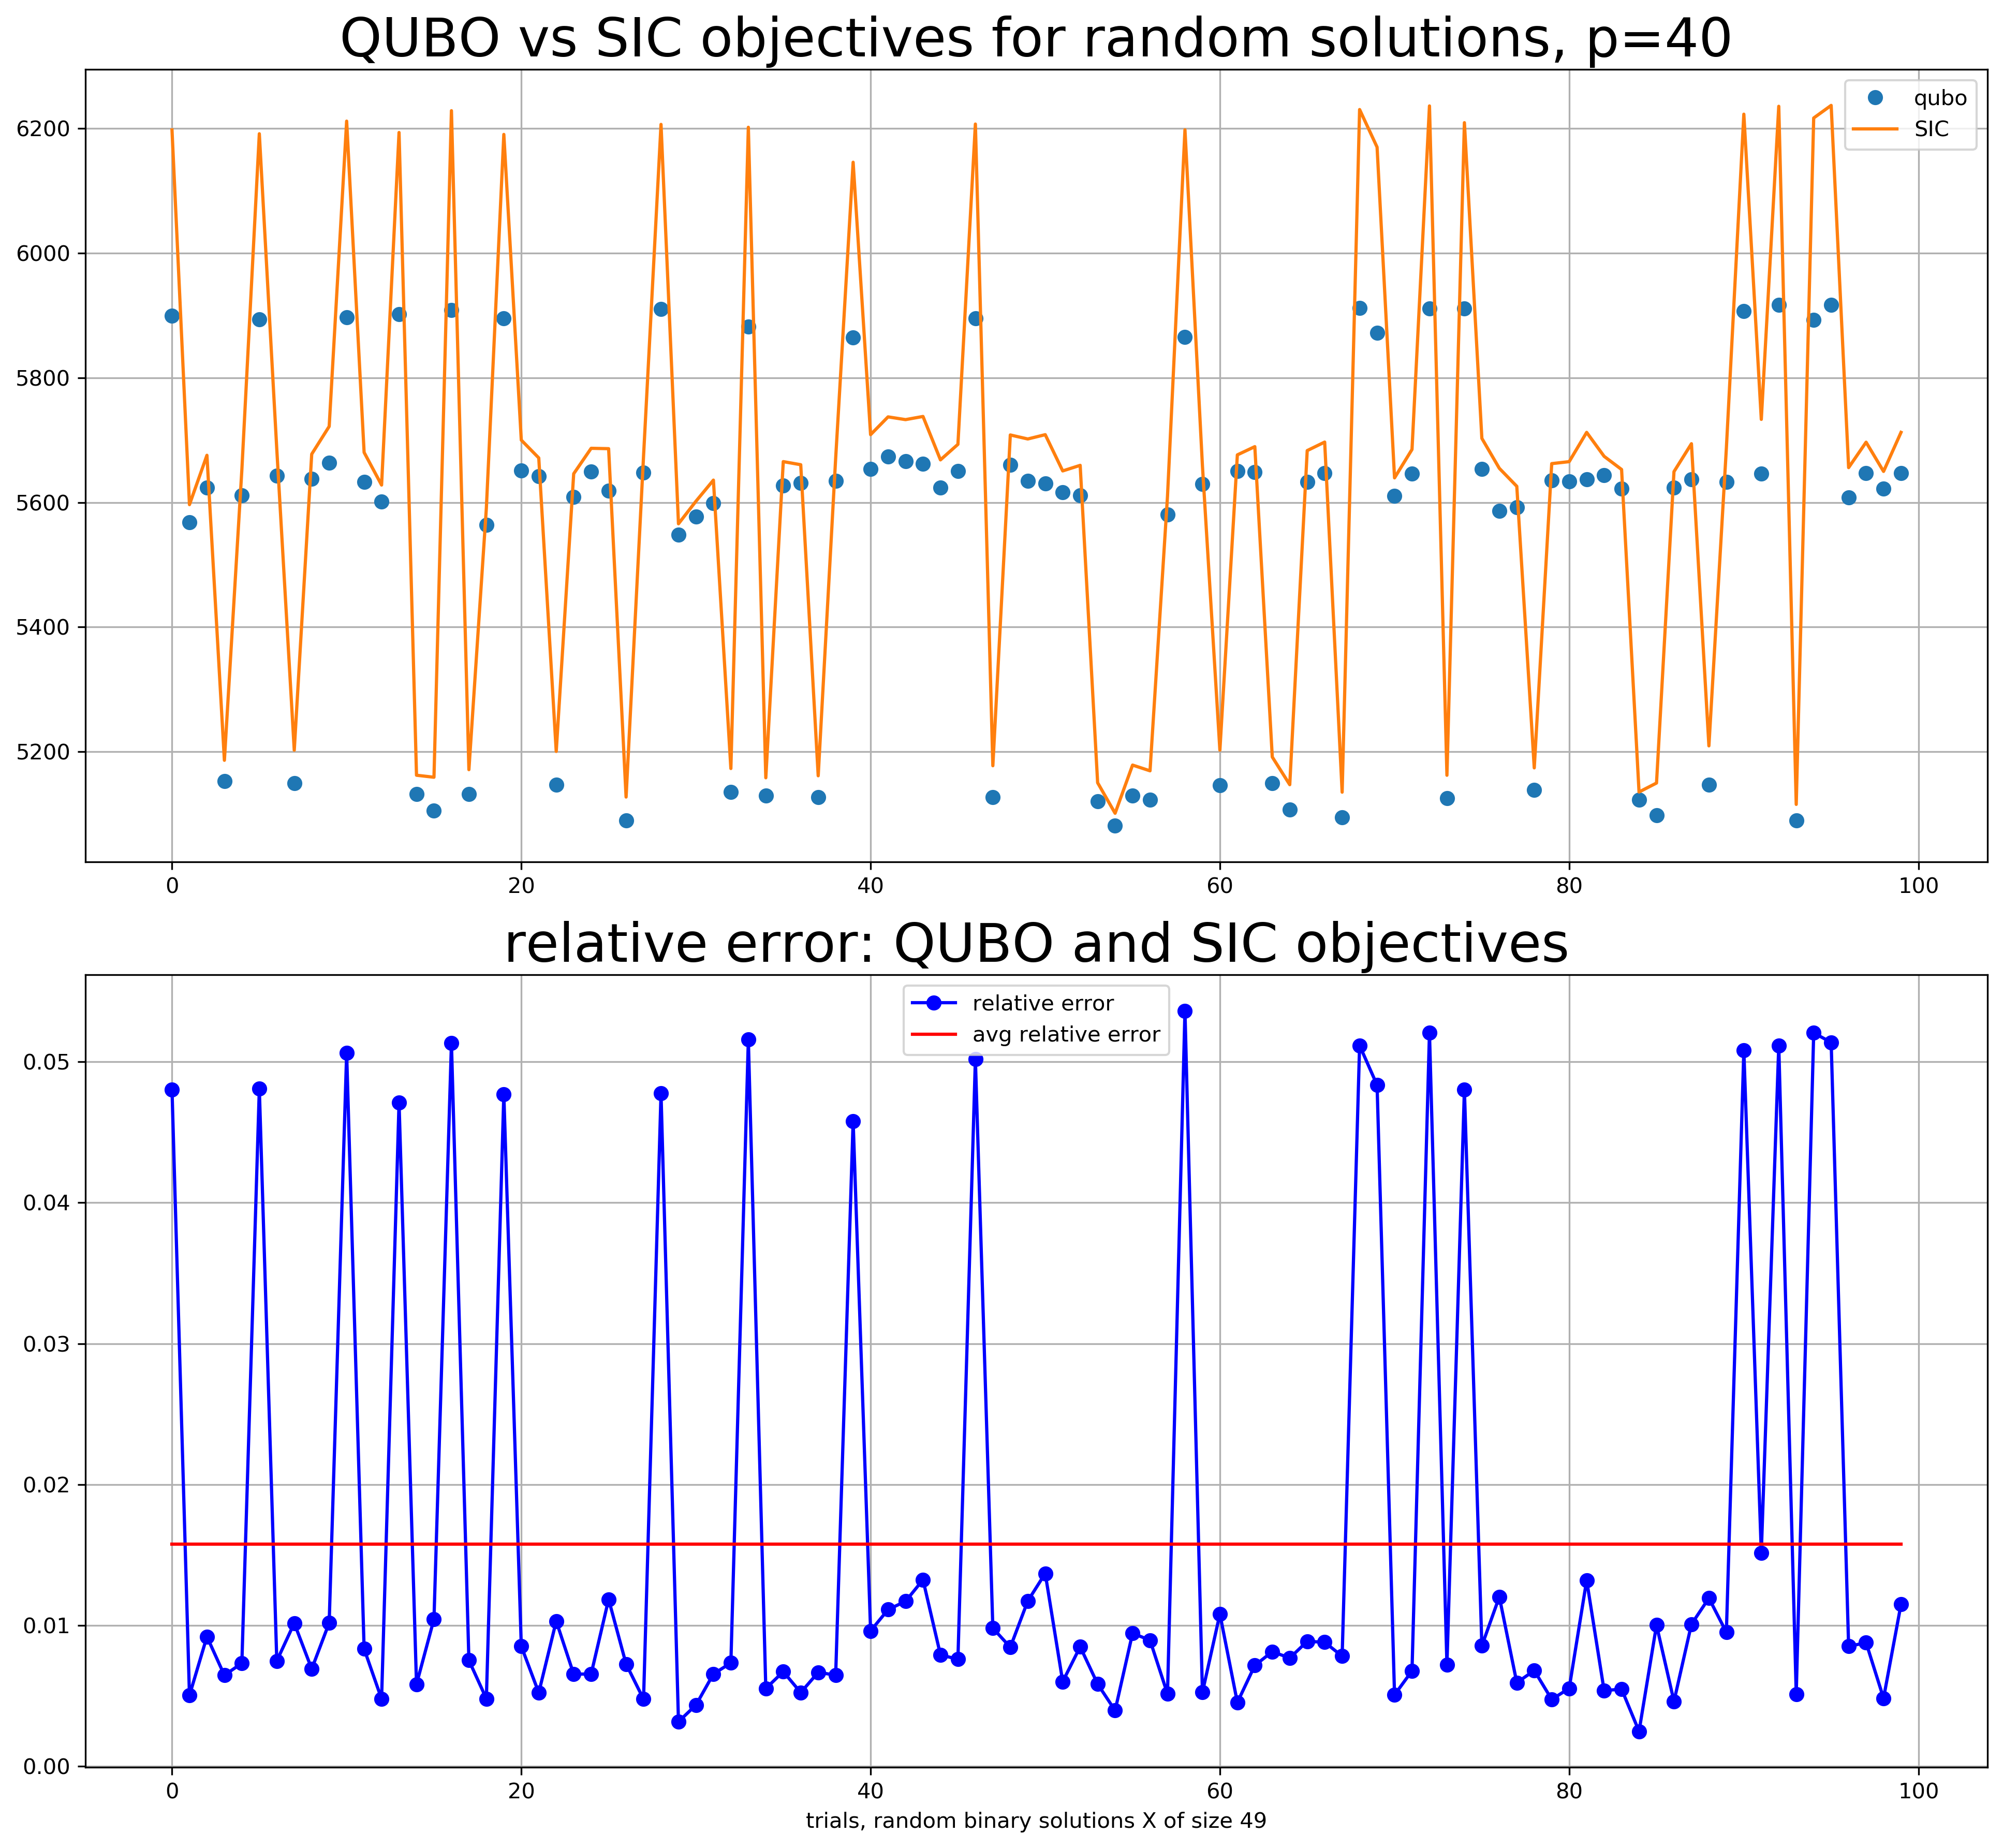

In [12]:
F = 0
p = 5
alpha = 1
beta = 1

trials = 100    # numbe of random soluions to try
n = 9    # stops to remove

sic_obj_values = np.zeros(trials)
qubo_obj_values = np.zeros(trials)


for i in range(trials):
    used_indices = []
    count = 0
    X = np.ones(49)
    np.random.seed()
    # change X so that it has n zeros
    while count < n:
        # do not alter the last 46,47,48,49 stops
        rand_idx = np.random.randint(0,46)
        if rand_idx not in used_indices:
            used_indices.append(rand_idx)
            X[rand_idx] = 0
            count += 1
            
    assert(np.sum(X) == 49-n)
    sic_obj_values[i] = alt_obj_func(X, stops, alpha, beta)
    lin, quad, offset = qubo_taylor_sparse_obj(stops,F, p, alpha, beta)

    bqm = dimod.BinaryQuadraticModel(lin, quad, 0, dimod.BINARY)
    qubo_obj_values[i] = bqm.energy(X)


rel_dif = np.abs(qubo_obj_values-sic_obj_values)/sic_obj_values
avg_rel_error = np.average(rel_dif)
print('AVG relative error percent QUBO and SIC:', '{:4.2f}%'.format(avg_rel_error*100))
DPI=300
FONTSIZE=25
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(13,12)
fig.set_dpi(DPI)
axs[0].set_title(f'QUBO vs SIC objectives for random solutions, p={49-n}', fontsize=FONTSIZE)
axs[0].plot(qubo_obj_values, 'o')
axs[0].plot(sic_obj_values)
# axs[0].set_yscale('log')
axs[0].grid(True)
axs[0].legend(['qubo', 'SIC'])
axs[1].grid(True)
axs[1].set_title('relative error: QUBO and SIC objectives', fontsize=FONTSIZE)
axs[1].plot(rel_dif, '-ob')
axs[1].plot(np.arange(0,trials), [avg_rel_error]*trials, 'r')
axs[1].set_xlabel('trials, random binary solutions X of size 49')
axs[1].legend(['relative error', 'avg relative error'])

fig.tight_layout()
plt.show()
plt.close()

### Graph layout of the objective function

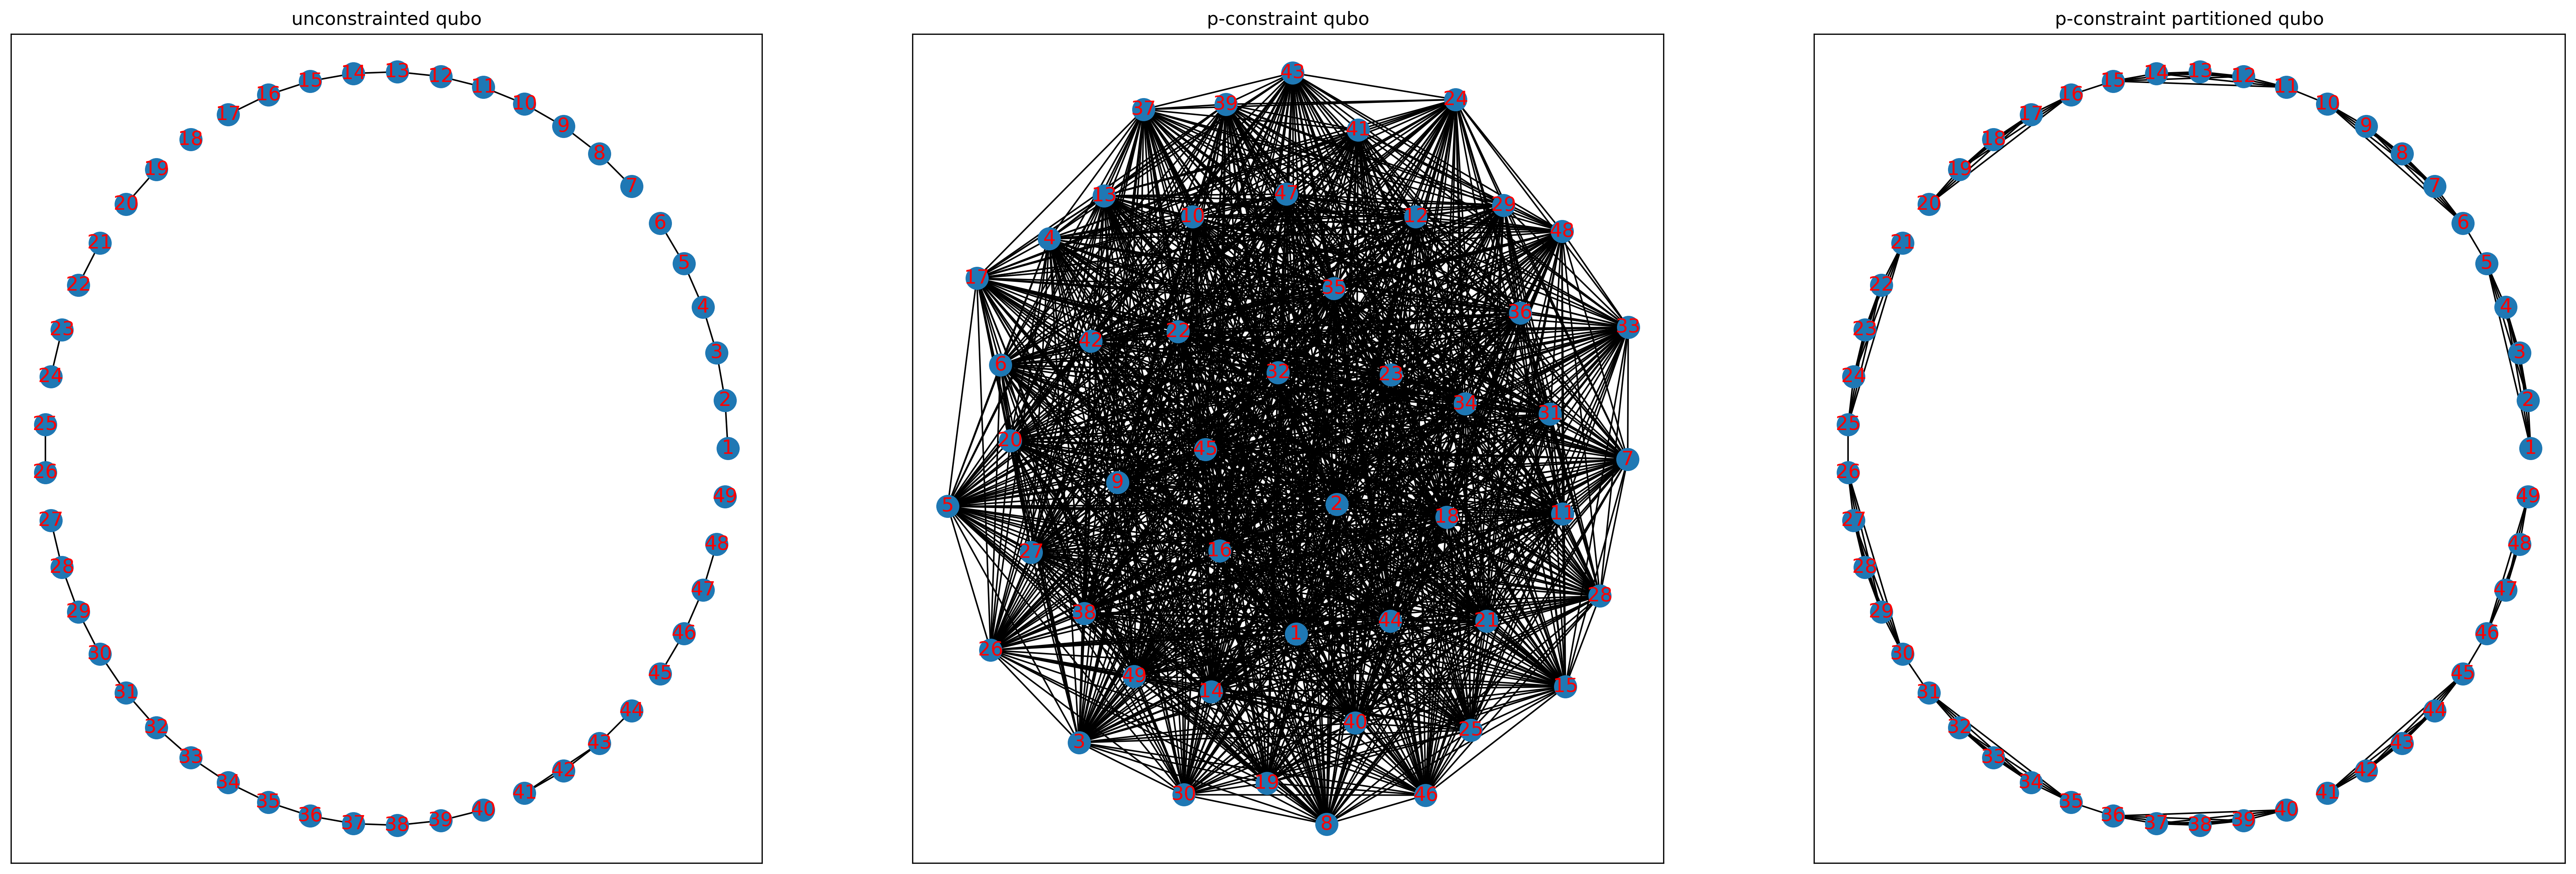

In [13]:
# no p-constraint
lin, quad, offset = qubo_taylor_sparse_obj(stops,F, p, alpha, beta, p_constraint=False)
bqm_no_constraint = dimod.BinaryQuadraticModel(lin, quad, 0, dimod.BINARY)
G_no_const = bqm_no_constraint.to_networkx_graph()

# with p-constraint, dense graph
lin, quad, offset = qubo_taylor_obj(stops,F, p, alpha, beta, p_constraint=True)
bqm_dense = dimod.BinaryQuadraticModel(lin, quad, 0, dimod.BINARY)
G_dense = bqm_dense.to_networkx_graph()

# with sparse p-constraint
lin, quad, offset = qubo_taylor_sparse_obj(stops,F, p, alpha, beta)
bqm_sparse_constraint = dimod.BinaryQuadraticModel(lin, quad, 0, dimod.BINARY)
G_sparse_const = bqm_sparse_constraint.to_networkx_graph()

vert_labels = {}
for stop in stops:
    vert_labels[stop.j] = stop.j+1

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(30,10)
fig.set_dpi(DPI)
axs[0].set_title('unconstrainted qubo')
axs[1].set_title('p-constraint qubo')
axs[2].set_title('p-constraint partitioned qubo')

pos = nx.shell_layout(G_no_const, scale=10)

nx.draw_networkx(G_no_const, pos=pos, node_size=200, ax=axs[0], labels=vert_labels, font_size=13, font_color='r')
nx.draw_networkx(G_dense, node_size=200, ax=axs[1], labels=vert_labels, font_size=13, font_color='r')
nx.draw_networkx(G_sparse_const, pos=pos, node_size=200, ax=axs[2], labels=vert_labels, font_size=13, font_color='r')



### Find a solution using D-Wave SA solver

In [14]:
solution_for_p = {}
# create bqm with no constraint and get its max energy
lin, quad, offset = qubo_taylor_sparse_obj(stops, F, p, alpha, beta, batch=5, p_constraint=False)
unconstrained_bqm = dimod.BinaryQuadraticModel(lin, quad, offset, dimod.BINARY)

unconstrained_bqm_energy = unconstrained_bqm.energy(np.ones(49))
print('energy unconstrained for X = 1,1,...,1:', unconstrained_bqm_energy)


batch_params = {
                45:{'p':8, 'b':9, 'Fs':0.0005},
                40:{'p':4, 'b':5, 'Fs':0.0005},
                35:{'p':5, 'b':7, 'Fs':0.001},
                30:{'p':3, 'b':5, 'Fs':0.003},
                25:{'p':2, 'b':4, 'Fs':0.004},
                20:{'p':2, 'b':5, 'Fs':0.007},
                14:{'p':2, 'b':7, 'Fs':0.009},
                10:{'p':1, 'b':5, 'Fs':0.008}
                }

max_energy = {}

for params in batch_params:
    p = batch_params[params]['p']
    batch = batch_params[params]['b']
    scale = batch_params[params]['Fs']
   # determine penalty F fo p-constraint
    F = scale*unconstrained_bqm_energy
    print('penlty term F:', F)
    # init a proper bqm with constraint and F
    lin, quad, offset = qubo_taylor_sparse_obj(stops, F, p, alpha, beta, batch=batch, p_constraint=True)
    bqm = dimod.BinaryQuadraticModel(lin, quad, offset, dimod.BINARY)


    # scale so min becomes max
    bqm.scale(-1)
    sampler = neal.SimulatedAnnealingSampler()

    # re-run iters times
    solution = 0
    optimal_value = 0
    iters = 100
    
    for i in range(iters):
        sampleSet = sampler.sample(bqm,beta_range=[1e-3, 10])
#         sampleSet = sampler.sample(bqm)

        X = np.array([value for value in sampleSet.first[0].values()])

        if sampleSet.first[1] < optimal_value:
            optimal_value = sampleSet.first[1]
            solution = X

    # check out solution feasibility
    bqm.scale(-1)
    # check the value of the constraint
    penalty_value = bqm.energy(solution) - unconstrained_bqm.energy(solution)
    obj_value = bqm.energy(solution) - penalty_value
    print('obj value with constrained subtracted at X*:', obj_value)
    print('unconstrained obj value at X*:', unconstrained_bqm.energy(solution))
    # check the solution on the SIC stop oriented objective
    sic_optimal = alt_obj_func(solution, stops, alpha, beta)
    print('\n################ SA RESULT ################')
    print('PENALTY AT X*:', penalty_value)
    print('TOTAL REMAINING STOPS:', np.sum(solution))
    print('OPTIMAL ENERGY AT X*:',bqm.energy(solution))
    print('SOLUTION X*:', solution)
    print('SIC OPTIMAL AT X*:', sic_optimal)
    max_energy[params] = bqm.energy(solution)
    solution_for_p[params] = solution.tolist()

json_object = json.dumps(solution_for_p, indent = 4) 
  
# Writing to json 
with open("solutions.json", "w") as outfile: 
    outfile.write(json_object)

energy unconstrained for X = 1,1,...,1: 5692.008836669733
penlty term F: 2.8460044183348665
obj value with constrained subtracted at X*: 5954.305250437698
unconstrained obj value at X*: 5954.305250437698

################ SA RESULT ################
PENALTY AT X*: 0.0
TOTAL REMAINING STOPS: 44
OPTIMAL ENERGY AT X*: 5954.305250437698
SOLUTION X*: [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1]
SIC OPTIMAL AT X*: 6259.364207379332
penlty term F: 2.8460044183348665
obj value with constrained subtracted at X*: 5950.211212222907
unconstrained obj value at X*: 5950.211212222907

################ SA RESULT ################
PENALTY AT X*: 0.0
TOTAL REMAINING STOPS: 40
OPTIMAL ENERGY AT X*: 5950.211212222907
SOLUTION X*: [1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1
 1 0 1 1 1 0 1 1 1 1 1 1]
SIC OPTIMAL AT X*: 6275.083508266653
penlty term F: 5.692008836669733
obj value with constrained subtracted at X*: 5943.19733

for p: 20  Q is not p.d.
for p: 14  Q is not p.d.
for p: 10  Q is not p.d.


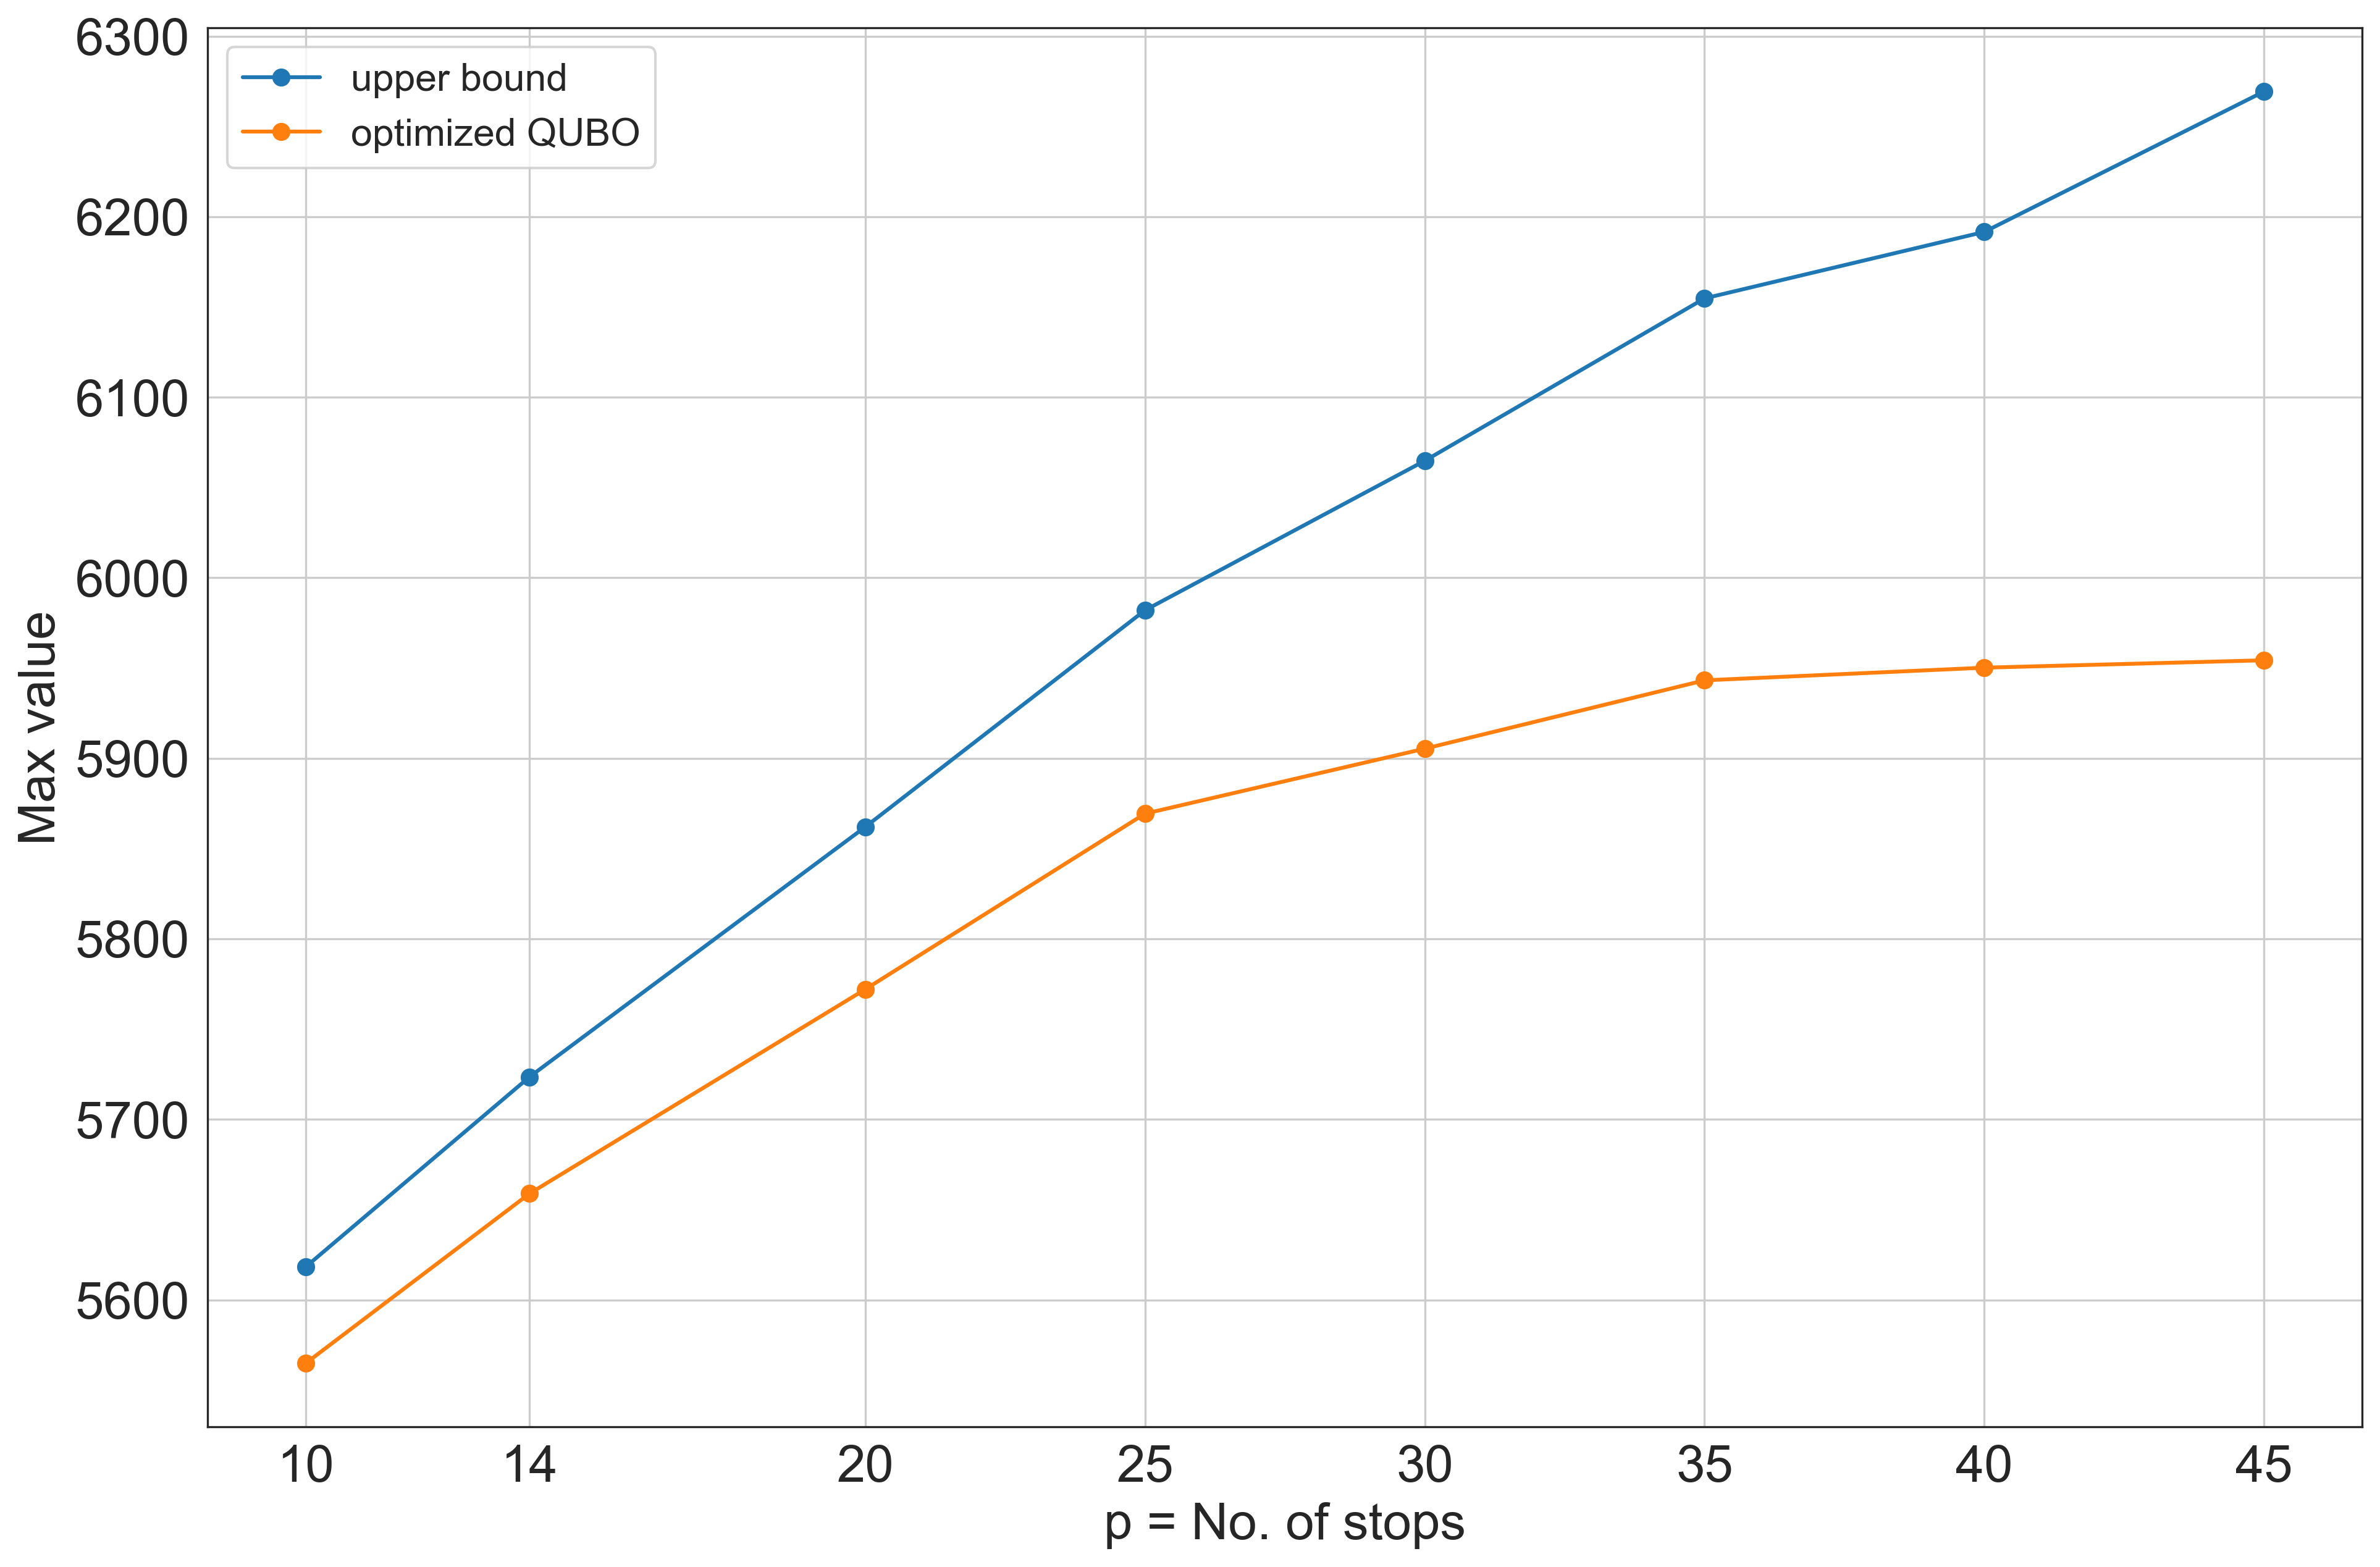

In [15]:
upperbound = {}
eigenvals_per_p = {}

for params in batch_params:
    p = batch_params[params]['p']
    batch = batch_params[params]['b']
    scale = batch_params[params]['Fs']
    # determine penalty F fo p-constraint
    F = scale*unconstrained_bqm_energy
    # init a proper bqm with constraint and F
    lin, quad, offset = qubo_taylor_sparse_obj(stops, F, p, alpha, beta, batch=batch, p_constraint=True)
    bqm = dimod.BinaryQuadraticModel(lin, quad, offset, dimod.BINARY)
    T = bqm.to_numpy_matrix().astype(np.float)
    Q = 0.5*(T+T.T)
    D, P = np.linalg.eig(Q)
    pos_def_check = D < 0
    
    if True in pos_def_check:
        print('for p:', params,' Q is not p.d.')
 
    D_sorted = np.sort(D)[::-1]
    eigenvals_per_p[params] = D_sorted[::-1]
    upperbound[params] = np.sum(D_sorted[:params]) + 2*offset
    
    
sns.set_style("white")
plt.figure(num=None, figsize=(15, 10), dpi=300, facecolor='w', edgecolor='k')
plt.plot(list(upperbound.keys()), list(upperbound.values()), '-o')
plt.plot(list(max_energy.keys()), list(max_energy.values()), '-o')
plt.xticks(list(max_energy.keys()))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('p = No. of stops',fontsize=20)
plt.ylabel('Max value', fontsize=20)
plt.legend(['upper bound','optimized QUBO'], fontsize=15)
plt.grid(True)
# plt.title('Problem optimal value for different p values.', fontsize=20)



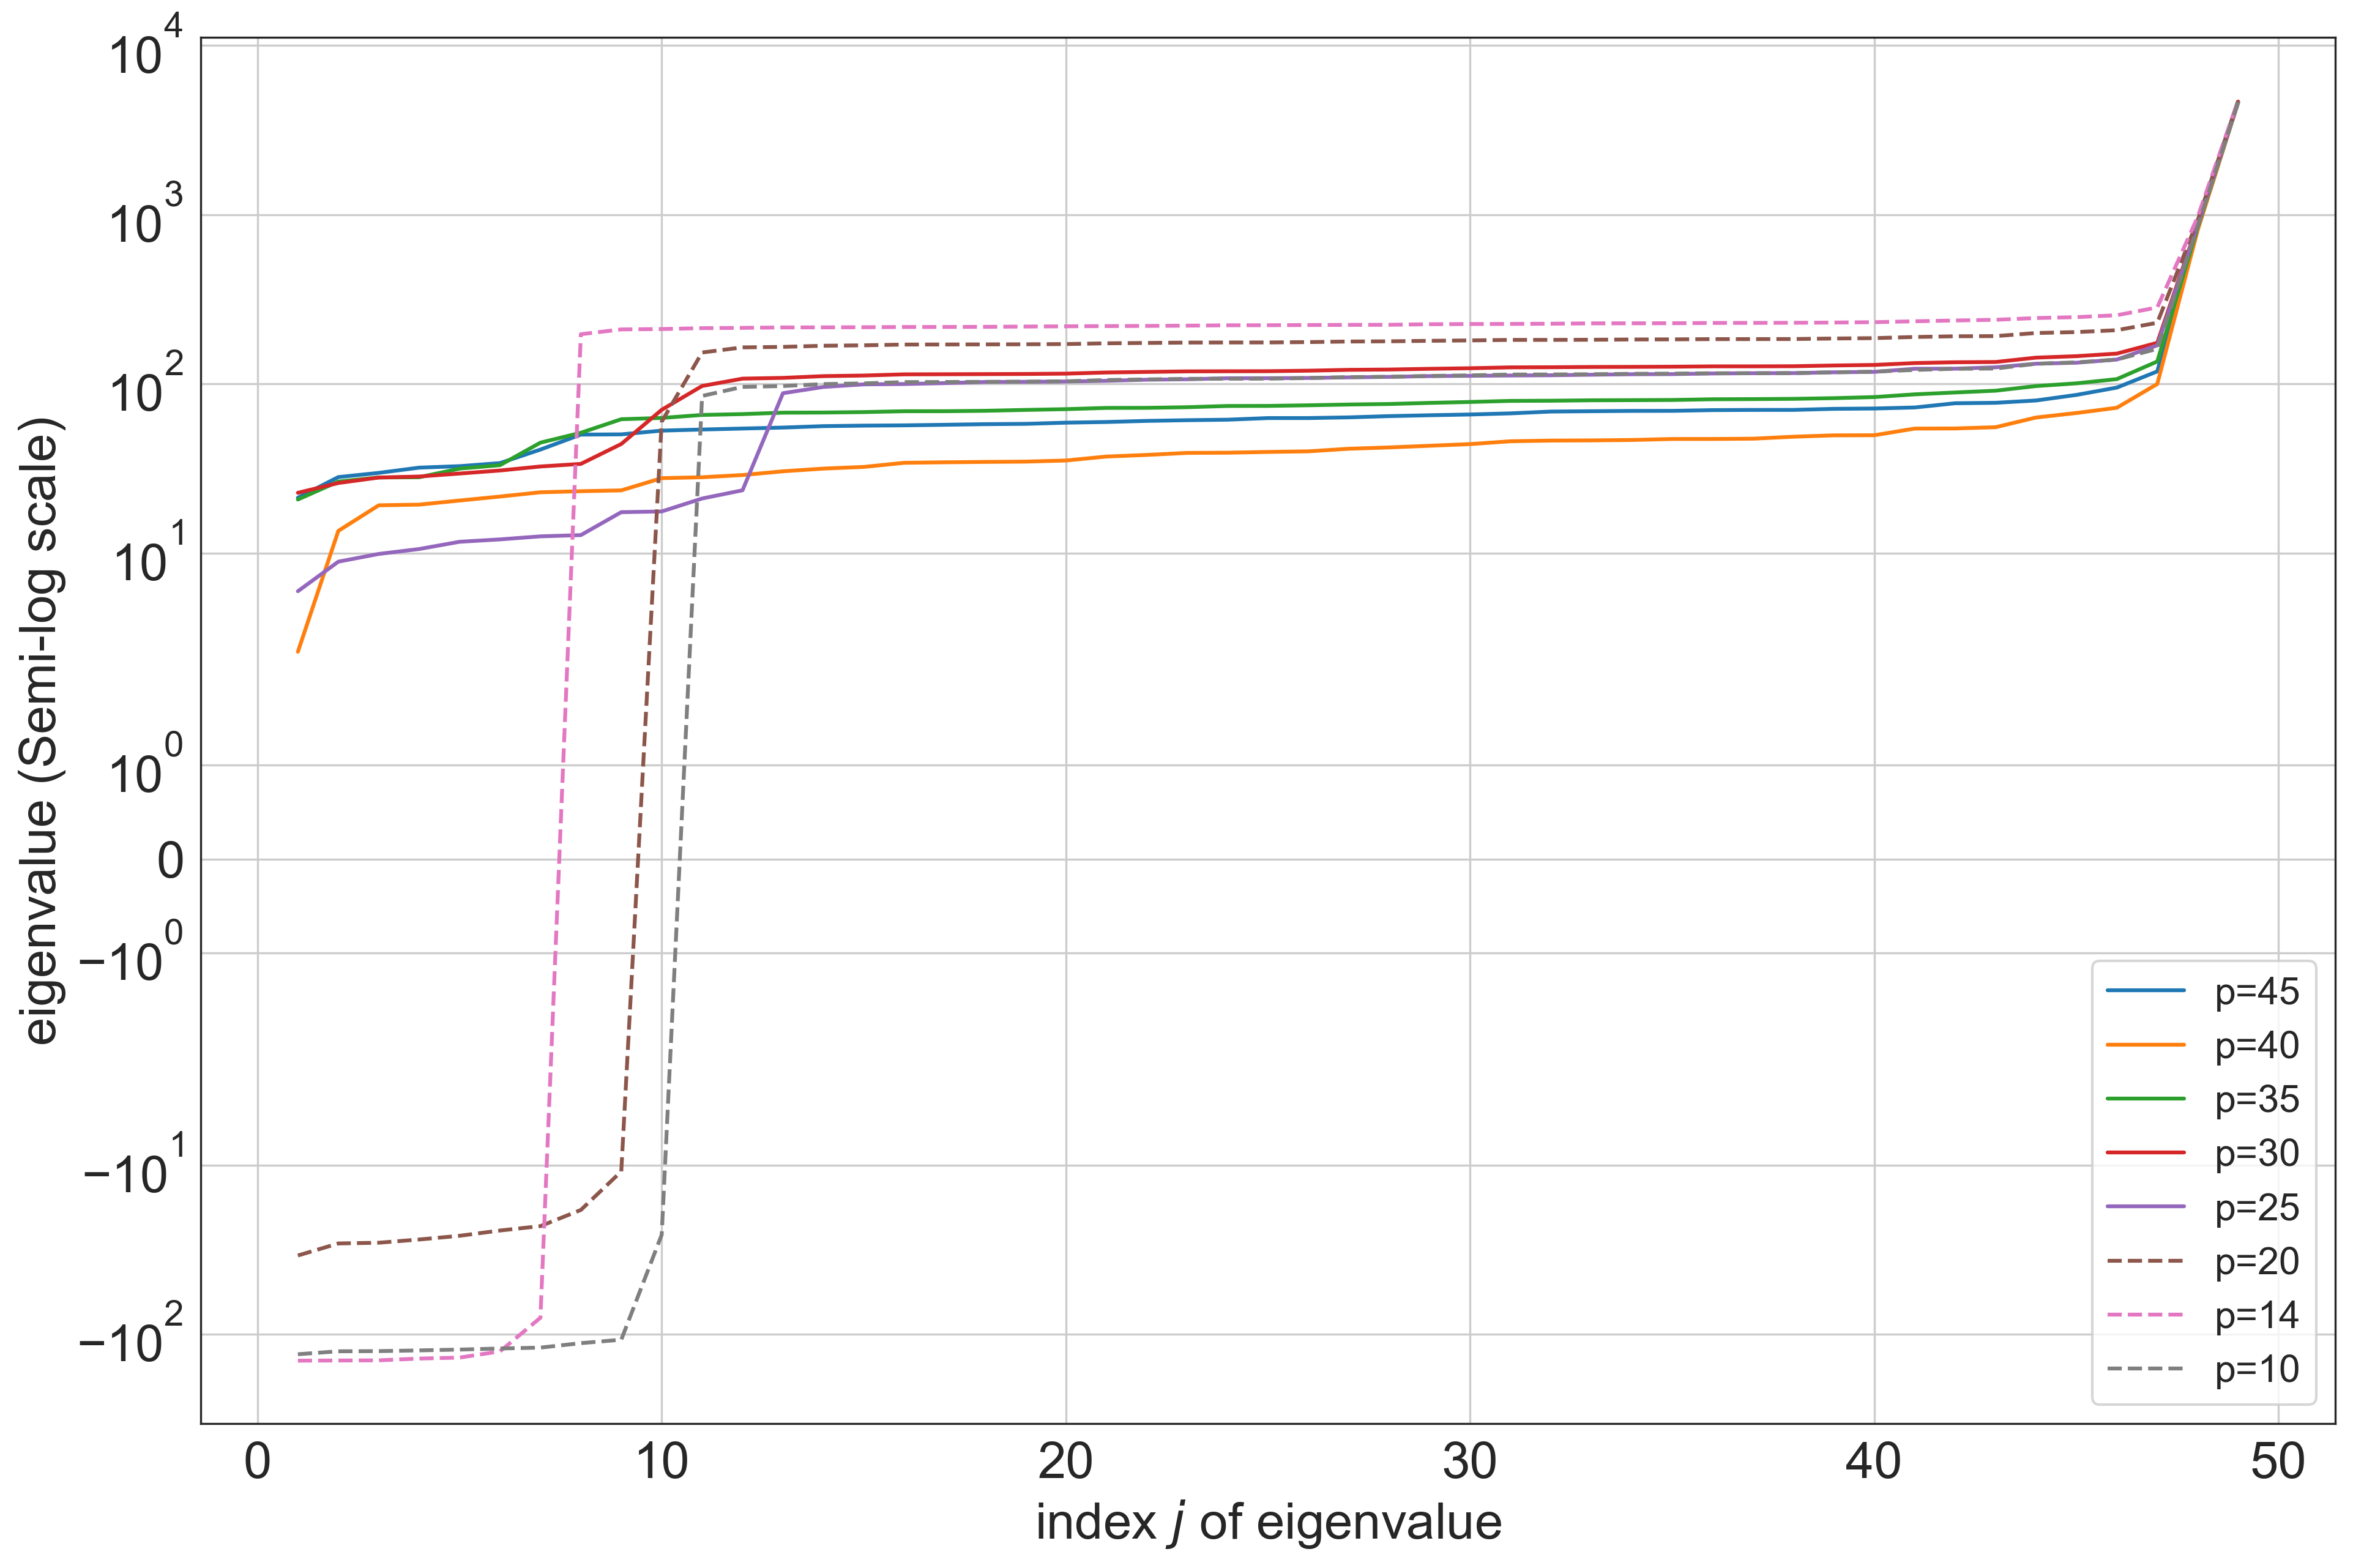

In [16]:
sns.set_style("white")
plt.figure(num=None, figsize=(15, 10), dpi=300, facecolor='w', edgecolor='k')
legend_labels = []

for param in eigenvals_per_p:
    lineStyle = ''
    x_labels = np.arange(1,len(eigenvals_per_p[param])+1)
    if True in (eigenvals_per_p[param] < 0):
        lineStyle = '--'
    plt.plot(x_labels, list(eigenvals_per_p[param]), lineStyle)
    legend_labels.append('p='+str(param))
    
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('index $j$ of eigenvalue',fontsize=20)
plt.ylabel('eigenvalue (Semi-log scale)', fontsize=20)
plt.yscale('symlog')
plt.legend(legend_labels, fontsize=15)
plt.grid(True)

### Use D-wave QPU
This only works if you have D-wave account.

### Make symmetric $Q$  and check its eigenvalues

In [17]:
np.set_printoptions(threshold=sys.maxsize)

bqm = dimod.BinaryQuadraticModel(lin, quad, offset, dimod.BINARY)
T = bqm.to_numpy_matrix().astype(np.float)
Q = 1/2*(T+T.T)
D, P = np.linalg.eig(Q)
D > 0
D_sorted = np.sort(D)[::-1]

# upper bound
upperbound = np.sum(D_sorted[:40]) + offset

# eigenvalue energy
eig_energy = np.dot(D,solution) + offset
xQx = np.dot(solution,np.dot(Q,solution)) + offset
print('upper bound:', upperbound,'eig_energy:', eig_energy, 'xQx:', xQx)

upper bound: 9157.783476016291 eig_energy: 1425.757606286582 xQx: 5564.866980471011


### Build the model using GEKKO 
This is depricated.

### Continues relaxation of the QUBO problem

In [18]:
combinat_sol = solution_for_p[40]



from gekko import GEKKO
m = GEKKO() # Initialize gekko
m.options.SOLVER=1
# optional solver settings with APOPT
m.solver_options = ['minlp_maximum_iterations 10000', \
                    # minlp iterations with integer solution
                    'minlp_max_iter_with_int_sol 1000', \
                    # treat minlp as nlp
                    'minlp_as_nlp 0', \
                    # nlp sub-problem max iterations
                    'nlp_maximum_iterations 1000', \
                    # 1 = depth first, 2 = breadth first
                    'minlp_branch_method 2', \
                    # maximum deviation from whole number
                    'minlp_integer_tol 0.1', \
                    # covergence tolerance
                    'minlp_gap_tol 0.01']

# determine penalty F fo p-constraint
F = 0.0005*unconstrained_bqm_energy
p=4
print('penlty term F:', F)

# init a proper bqm with constraint and F
lin, quad, offset = qubo_taylor_sparse_obj(stops, F, p, alpha, beta, batch=5, p_constraint=True)
bqm = dimod.BinaryQuadraticModel(lin, quad, offset, dimod.BINARY)
T = bqm.to_numpy_matrix().astype(np.float)
Q = 1/2*(T+T.T)



_n,n = Q.shape

X = []
for i in range(0, n):
    randVal = np.round(np.random.rand(1))[0]
    x = m.Var(value=randVal,lb=0,ub=1, integer=False)
    X.append(x)
    

linear = m.Intermediate(0)
quadratic = m.Intermediate(0)

for i in range(n):
    linear += m.Intermediate(m.Const(Q[i,i])*X[i])
    for j in range(n):
        if i == j:
            continue

        if np.abs(Q[i,j]) < 10e-5:
            continue
        quadratic += m.Intermediate(m.Const(Q[i,j])*X[i]*X[j])

f = m.Intermediate(linear+quadratic+offset)
m.Obj(-f)

sol = m.solve(disp=False)
relaxedX = [int(x[0]) for x in X]
print('maximum:', abs(m.options.objfcnval))
print('retained stops:', np.sum(relaxedX))
print('conti solution:', relaxedX)
print('combinat solution:', combinat_sol)

print(np.array(combinat_sol)==np.array(relaxedX))


penlty term F: 2.8460044183348665
maximum: 5948.1061999
retained stops: 40
conti solution: [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
combinat solution: [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]


### Do GIS plot using ggplot

### The plot below is produced using standard matplotlib tools